# Recommendation system for movies

**Benedikt Roth**

**data-pt-ber-08-20**

## Overview
Main project: Building recommendation systems based on different techniques<br>
Hypothese/Question to answer: Is machine Learning the best apporach to build a recommendation system on?<br>
Tesing: Building different recommendation systems using different techniques and compare them to machine learning approach<br>

Sub project: Clustering people based on average genre ratings<br>
Hypothesis: There is a genre which mostly drives different clusters for movies?<br>
Tesing: Building an unsupervies machine leanring alg to identify most important feature for clustering people based on movie genres.<br>

Main structure:<br>
Process:<br>
1.Data Acquisition<br>
2.Data cleaning<br>
3.Data exploration and analysis<br>
4. Sub project:<br>
>Feature selection<br>
>Train Unsupervised Learning model<br>
>Model evaluation using Elbow method and Silhouette score<br>
    
5. Building recommendation Engines:
>Content Based Filtering<br>
>Item-Item based Filtering<br>
>User-Item based Filtering<br>
>Model based Filtering<br>
>Model based Filtering using ML approach:<br>
>Train/Test Split<br>
>Train Model<br>
>Tuning Model<br>
>Evaluate Model<br>

6.Conclusion

## Data Preparation
### Overview:
Data from MovieLen: MovieLen is a non-commercial, personalized movie recommendation website
https://grouplens.org/datasets/movielens/

size:(105339, 7)
datatypes:int, float, timestamp

### Data Ingestion

In [50]:
# Importing packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from scipy.sparse.linalg import svds
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
import random

In [51]:
### Loading datasets
movies_df = pd.read_csv("./Dataset_original/movies.csv")
ratings_df = pd.read_csv("./Dataset_original/ratings.csv")

In [52]:
# Displaying movies dataset
movies_df.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [53]:
# Checking shape of dataset
movies_df.shape

(10329, 3)

In [54]:
# Checking datatypes
print(movies_df.dtypes)

movieId     int64
title      object
genres     object
dtype: object


In [55]:
# Describing dataset
movies_df.describe()

movieId
count   10329.000000
mean    31924.282893
std     37734.741149
min         1.000000
25%      3240.000000
50%      7088.000000
75%     59900.000000
max    149532.000000

In [56]:
# Displaying dataset
ratings_df.head()

userId  movieId  rating   timestamp
0       1       16     4.0  1217897793
1       1       24     1.5  1217895807
2       1       32     4.0  1217896246
3       1       47     4.0  1217896556
4       1       50     4.0  1217896523

In [57]:
# Checking shape of dataset
ratings_df.shape

(105339, 4)

In [58]:
# Checking datatypes
print(ratings_df.dtypes)

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object


In [59]:
# Describing dataset
ratings_df.describe()

userId        movieId         rating     timestamp
count  105339.000000  105339.000000  105339.000000  1.053390e+05
mean      364.924539   13381.312477       3.516850  1.130424e+09
std       197.486905   26170.456869       1.044872  1.802660e+08
min         1.000000       1.000000       0.500000  8.285650e+08
25%       192.000000    1073.000000       3.000000  9.711008e+08
50%       383.000000    2497.000000       3.500000  1.115154e+09
75%       557.000000    5991.000000       4.000000  1.275496e+09
max       668.000000  149532.000000       5.000000  1.452405e+09

In [60]:
# Converting datetype
from datetime import datetime

ratings_df["timestamp"] = ratings_df["timestamp"].apply(datetime.fromtimestamp)
ratings_df["year"] = ratings_df["timestamp"].dt.year
ratings_df["month"] = ratings_df["timestamp"].dt.month
ratings_df["date"] = ratings_df["timestamp"].dt.date

In [61]:
ratings_df.head()

userId  movieId  rating           timestamp  year  month        date
0       1       16     4.0 2008-08-05 02:56:33  2008      8  2008-08-05
1       1       24     1.5 2008-08-05 02:23:27  2008      8  2008-08-05
2       1       32     4.0 2008-08-05 02:30:46  2008      8  2008-08-05
3       1       47     4.0 2008-08-05 02:35:56  2008      8  2008-08-05
4       1       50     4.0 2008-08-05 02:35:23  2008      8  2008-08-05

In [62]:
# Merging datasets on movie_id
all_movies  = pd.merge(left=movies_df, right=ratings_df, how="left", on = "movieId")
print("Total dataset: {}".format(all_movies.shape[0]))
all_movies.head()

Total dataset: 105343


movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   userId  rating           timestamp    year  month        date  
0     2.0     5.0 1997-03-22 17:08:15  1997.0    3.0  1997-03-22  
1     5.0     4.0 2011-04-22 21:37:19  2011.0    4.0  2011-04-22  
2     8.0     5.0 1997-03-17 16:02:13  1997.0    3.0  1997-03-17  
3    11.0     4.0 1996-12-17 10:43:30  1996.0   12.0  1996-12-17  
4    14.0     4.0 1996-12-28 10:44:46  1996.0   12.0  1996-12-28

In [63]:
# Checking shape of dataset
all_movies.shape

(105343, 9)

In [64]:
# Checking datatypes
print(all_movies.dtypes)

movieId               int64
title                object
genres               object
userId              float64
rating              float64
timestamp    datetime64[ns]
year                float64
month               float64
date                 object
dtype: object


In [65]:
# Describing dataset
all_movies.describe()

movieId         userId         rating           year  \
count  105343.000000  105339.000000  105339.000000  105339.000000   
mean    13382.696373     364.924539       3.516850    2005.324970   
std     26172.698128     197.486905       1.044872       5.718372   
min         1.000000       1.000000       0.500000    1996.000000   
25%      1073.000000     192.000000       3.000000    2000.000000   
50%      2497.000000     383.000000       3.500000    2005.000000   
75%      5991.000000     557.000000       4.000000    2010.000000   
max    149532.000000     668.000000       5.000000    2016.000000   

               month  
count  105339.000000  
mean        6.477269  
std         3.548109  
min         1.000000  
25%         3.000000  
50%         6.000000  
75%        10.000000  
max        12.000000

### Data Wrangling and Cleaning

In [66]:
# Checking NULL values per row
amount_of_null_values_per_row = all_movies.isnull().sum(axis=1)
pd.Series(amount_of_null_values_per_row).value_counts()

0    105339
6         4
dtype: int64

In [67]:
# Checking NULL values per variable
missing = all_movies.isnull().sum().sort_values(ascending=False)
missing

date         4
month        4
year         4
timestamp    4
rating       4
userId       4
genres       0
title        0
movieId      0
dtype: int64

In [68]:
# Checking NULL values per column in relation to all values of a column
def missing_values_table(df):
    mis_val = all_movies.isnull().sum()
    mis_val_percent = 100 * all_movies.isnull().sum()/len(all_movies)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : "Missing Values", 1 : "% of Total Values"})
    return mis_val_table_ren_columns
missing_values_table(all_movies)

Missing Values  % of Total Values
movieId                 0           0.000000
title                   0           0.000000
genres                  0           0.000000
userId                  4           0.003797
rating                  4           0.003797
timestamp               4           0.003797
year                    4           0.003797
month                   4           0.003797
date                    4           0.003797

In [69]:
# Dropping NULL values
all_movies.dropna(inplace=True) 

### Data Storage

In [70]:
# Saving the cleaned data as csv
all_movies.to_csv(r"Dataset_cleaned\Dataset_cleaned.csv")

## Data Analysis

### Overview

Finding outliers and most interesting findings in dataset using statistical concepts as well as data visualisation techniques

In [71]:
# Getting number of unique users and movies in dataset
print(f"Number of Unique Users: {all_movies['userId'].nunique()}")
print(f"Number of Movies: {all_movies['movieId'].nunique()}")

Number of Unique Users: 668
Number of Movies: 10325


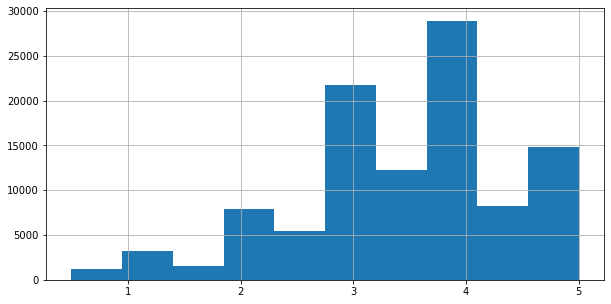

In [72]:
# Exploring distribution of different ratings
ratings_df["rating"].hist(figsize=(10, 5))

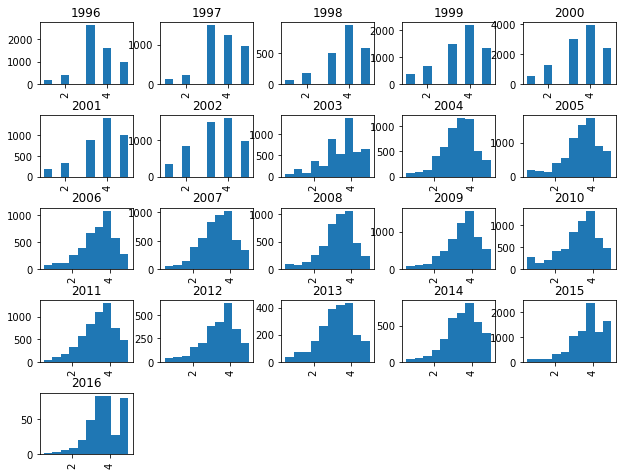

In [76]:
# Exploring distribution of different ratings over time
ratings_df["rating"].hist(by=ratings_df["year"], figsize=(10, 8))

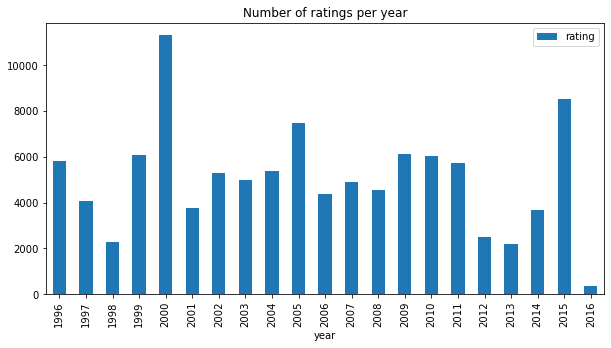

In [74]:
# Exploring amount of ratings per year
ratings_df[['year', 'rating']].groupby(['year']).count().reset_index().plot.bar(x='year', y='rating', title='Number of ratings per year', figsize=(10, 5));

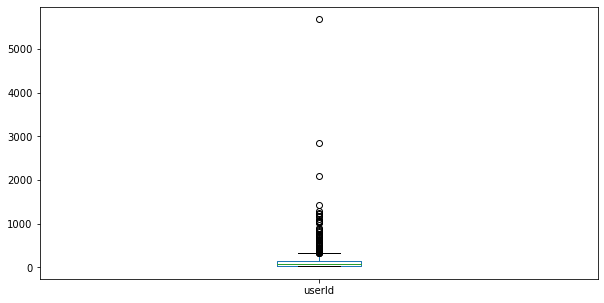

In [78]:
# Boxplot amount of ratings per user
ratings_df["userId"].value_counts().plot.box(figsize=(10, 5))

In [ ]:
# There are some extreme values to seen, but as it still seems reasonable, extreme value will stay in data

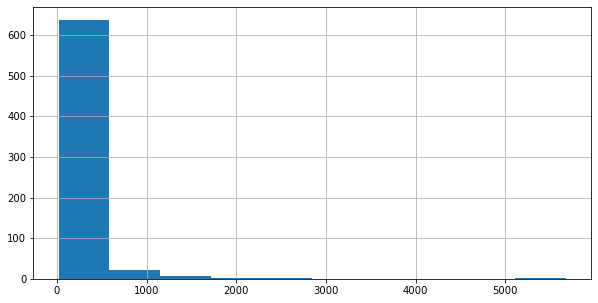

In [81]:
# Distribution of ratings per user
ratings_df["userId"].value_counts().hist(figsize=(10, 5))
plt.show()

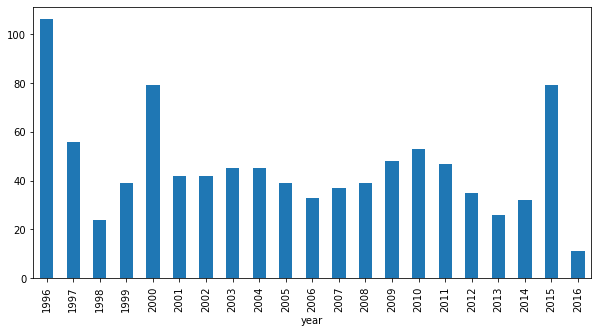

In [84]:
# Exploring when user entered the dataset
ratings_df[["year", "userId"]].groupby(["year"])["userId"].nunique().plot.bar(x="year", y="userId", figsize=(10, 5))
plt.show()

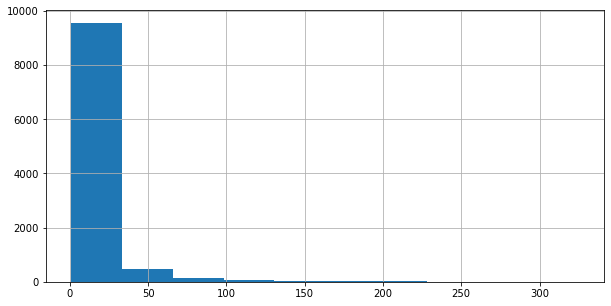

In [86]:
# Exploring amoung of ratings per movie
ratings_df["movieId"].value_counts().hist(figsize=(10, 5))
plt.show()

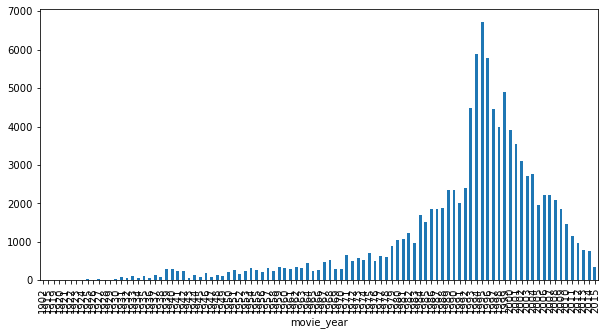

In [90]:
# Exploring release date per movie
all_movies["movie_year"] = all_movies["title"].str.extract("\((\d{4})\)", expand=True)
year_counts = all_movies[["title", "movie_year"]].groupby("movie_year").size()
year_counts.plot.bar("movie_year", "title", figsize=(10, 5))
plt.show()

### Visualisations

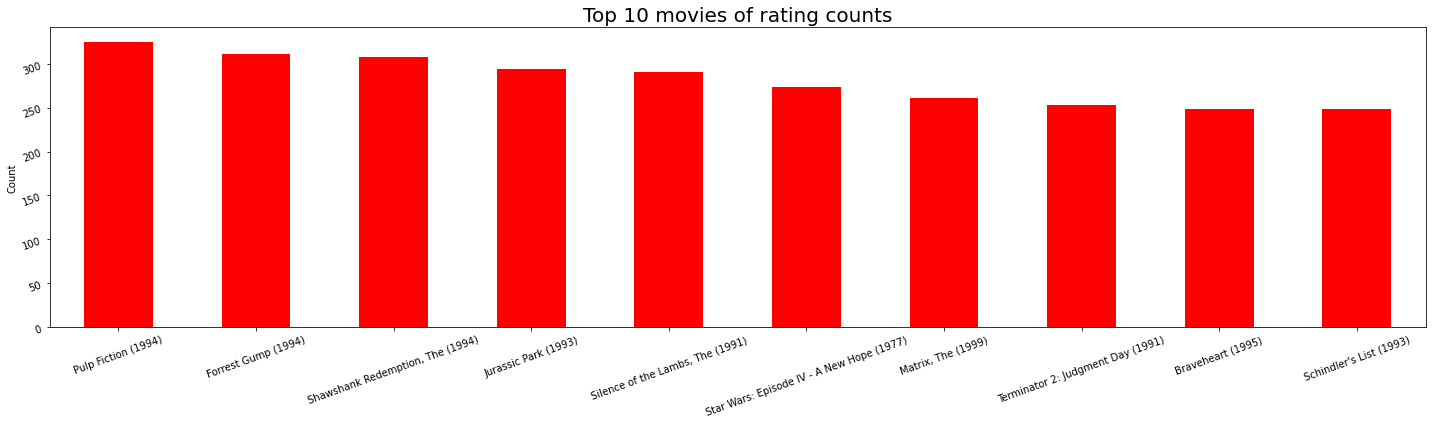

In [38]:
# top 10 movies per year
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20,6))
all_movies["title"].value_counts()[:10].plot(kind = "bar", ax = ax, color="red")
ax.set_title("Top 10 movies of rating counts", fontsize = 20)
ax.tick_params(labelrotation = 20)
ax.set_ylabel("Movies Title")
ax.set_ylabel("Count")
plt.tight_layout()

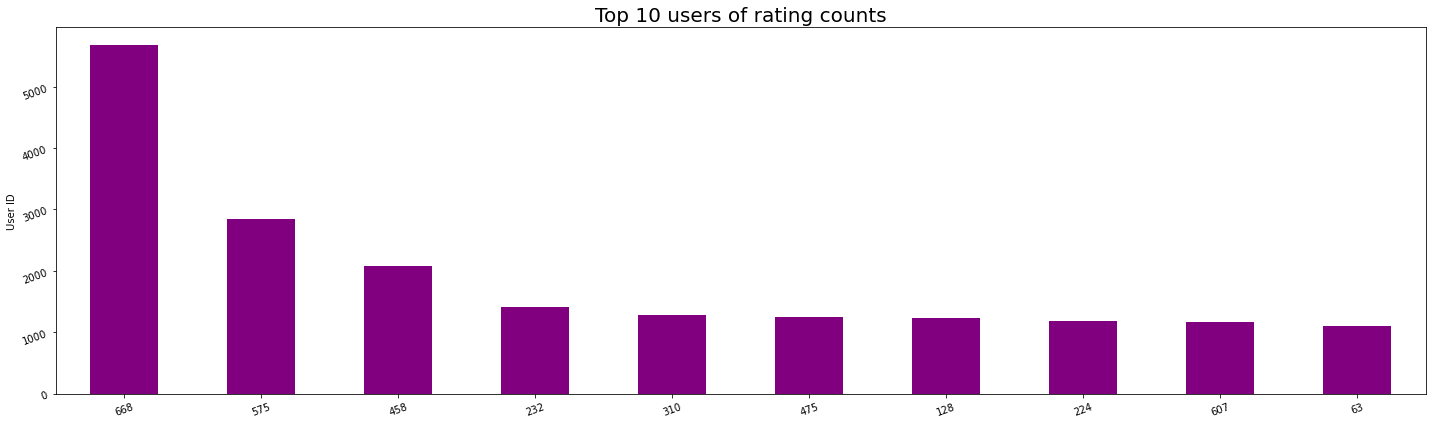

In [91]:
# top 10 most rated users
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20,6))
ratings_df["userId"].value_counts()[:10].plot(kind = 'bar', ax = ax, color="purple")
ax.set_title("Top 10 users of rating counts", fontsize = 20)
ax.tick_params(labelrotation = 20)
ax.set_ylabel("Count")
ax.set_ylabel("User ID")
plt.tight_layout()

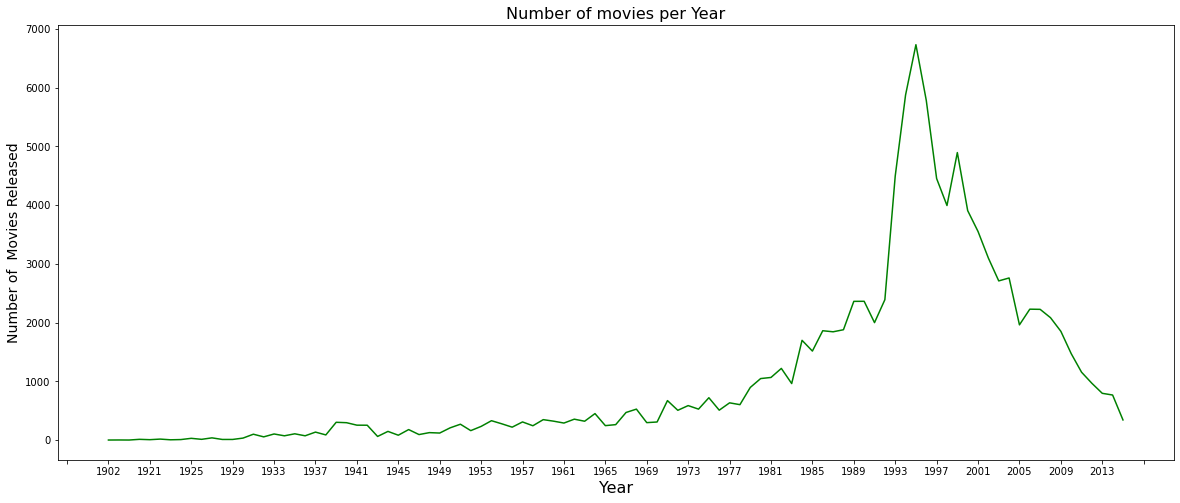

In [92]:
# numbers of movies per year
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(year_counts.index, year_counts.values,color='green')
ax.xaxis.set_major_locator(plt.MaxNLocator(30)) 
plt.title("Number of movies per Year", fontsize=16)
plt.xlabel("Year", fontsize= 16)
plt.ylabel("Number of  Movies Released", fontsize=14)
plt.show()

In [93]:
# top watched genres
movies_df["genres"] = movies_df["genres"].replace(to_replace="(no genres listed)", value="")
generlist = movies_df["genres"].apply(lambda allgeners : str(allgeners).split("|"))
generlist

0        [Adventure, Animation, Children, Comedy, Fantasy]
1                           [Adventure, Children, Fantasy]
2                                        [Comedy, Romance]
3                                 [Comedy, Drama, Romance]
4                                                 [Comedy]
                               ...                        
10324                        [Animation, Children, Comedy]
10325                                             [Comedy]
10326                                             [Comedy]
10327                                              [Drama]
10328                                                   []
Name: genres, Length: 10329, dtype: object

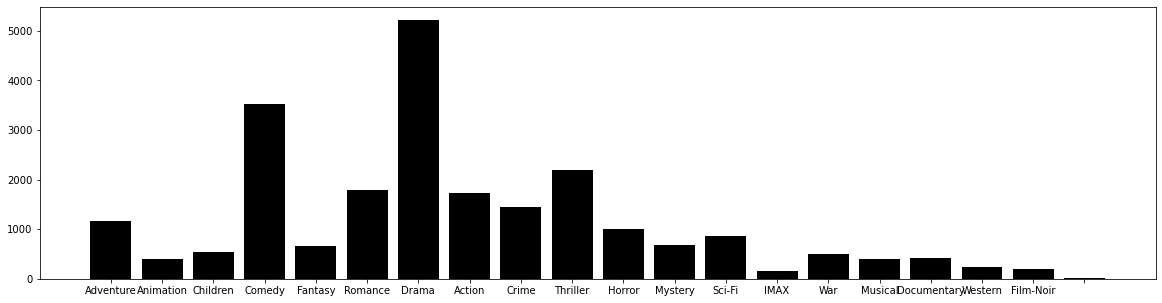

In [94]:
plt.figure(figsize=(20,5))
count = {}

for generlist_movie in generlist:
    for gener in generlist_movie:
        if(count.get(gener,False)):
            count[gener]=count[gener]+1
        else:
            count[gener] = 1
            
plt.bar(count.keys(),count.values(),color="black")
plt.show()

## Data Analysis sub project
Sub project: Clustering people based on average genre ratings<br>
Hypothesis: There is a genre which mostly drives different clusters for movies?<br>
Tesing: Building an unsupervies machine leanring alg to identify most important feature for clustering people based on movie genres.<br>

In [139]:
# importing packages for this sub project
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn import datasets

### Data Exploration and Visualization

In [95]:
# Creating new dataframe for avarage ratings per genres per user
ratings = ratings_df
movies = movies_df
genres= ["Adventure", "Animation", "Children", "Comedy", "Fantasy", "Romance", "Drama", "Action", "Crime", "Thriller", "Horror", "Mystery", "Sci-Fi", "IMAX", "War", "Musical", "Documentary", "Western", "Film-Noir" ]
#columns
column_names = ["avg_Adventure", "avg_Animation", "avg_Children", "avg_Comedy", "avg_Fantasy", "avg_Romance", "avg_Drama", "avg_Action", "avg_Crime", "avg_Thriller", "avg_Horror", "avg_Mystery", "avg_Sci-Fi", "avg_IMAX", "avg_War", "avg_Musical", "avg_Documentary", "avg_Western", "avg_Film-Noir" ]
#Empty frame
genre_ratings = pd.DataFrame()
#loop on genres
for genre in genres:      
  #getting genres
  genre_movies = movies[movies["genres"].str.contains(genre) ]
  #avarage mean of ratings for this genre
  avg_genre_votes_per_user = ratings[ratings["movieId"].isin(genre_movies["movieId"])].loc[:, ["userId", "rating"]].groupby(["userId"])["rating"].mean().round(2)
  #concate both empty dataframe with avg mean ratings
  genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
#add columns in empty dataframe
genre_ratings.columns = column_names
genre_ratings.head()


avg_Adventure  avg_Animation  avg_Children  avg_Comedy  avg_Fantasy  \
1           3.69           4.00          3.17        3.27         3.81   
2           4.00           4.50          4.33        3.55         4.25   
3           3.44           3.50          3.80        3.74         3.40   
4           4.24           4.75          4.33        4.02         4.25   
5           3.55           4.10          3.90        3.44         3.84   

   avg_Romance  avg_Drama  avg_Action  avg_Crime  avg_Thriller  avg_Horror  \
1         3.34       3.84        3.83       4.21          3.87        3.69   
2         3.75       4.36        3.89       4.33          3.92         NaN   
3         3.64       3.97        3.23       4.00          3.71        4.00   
4         4.16       4.34        3.79       3.94          3.72        3.50   
5         3.74       2.68        2.76       2.58          1.77        3.00   

   avg_Mystery  avg_Sci-Fi  avg_IMAX  avg_War  avg_Musical  avg_Documentary  \
1         3.81        3.40      3.88     4.20         4.00              0.5   
2         3.50        3.80       NaN      NaN         4.00              NaN   
3         4.25        3.33      4.00     3.67         3.67              5.0   
4         4.40        4.33       NaN     4.56         4.33              NaN   
5         2.67        3.67      4.28     0.50         4.09              NaN   

   avg_Western  avg_Film-Noir  
1          3.5           4.00  
2          NaN            NaN  
3          4.0            NaN  
4          4.2           4.33  
5          NaN            NaN

In [96]:
genre_ratings.describe()

avg_Adventure  avg_Animation  avg_Children  avg_Comedy  avg_Fantasy  \
count     667.000000     573.000000     614.00000  667.000000   645.000000   
mean        3.592159       3.617923       3.47456    3.568801     3.568760   
std         0.585551       0.786227       0.74576    0.514119     0.671811   
min         0.500000       0.500000       0.50000    0.930000     0.780000   
25%         3.250000       3.080000       3.00000    3.275000     3.120000   
50%         3.620000       3.700000       3.50000    3.590000     3.580000   
75%         4.000000       4.080000       4.00000    3.900000     4.000000   
max         5.000000       5.000000       5.00000    5.000000     5.000000   

       avg_Romance   avg_Drama  avg_Action   avg_Crime  avg_Thriller  \
count   663.000000  668.000000  666.000000  663.000000    666.000000   
mean      3.665475    3.797275    3.564625    3.778612      3.632102   
std       0.575363    0.468231    0.578162    0.586997      0.537800   
min       0.670000    1.620000    1.500000    0.500000      1.640000   
25%       3.370000    3.517500    3.200000    3.460000      3.310000   
50%       3.700000    3.820000    3.580000    3.820000      3.680000   
75%       4.040000    4.140000    3.967500    4.170000      4.000000   
max       5.000000    5.000000    5.000000    5.000000      5.000000   

       avg_Horror  avg_Mystery  avg_Sci-Fi    avg_IMAX     avg_War  \
count  596.000000   621.000000  659.000000  448.000000  601.000000   
mean     3.488322     3.746425    3.519621    3.766496    3.896356   
std      0.816810     0.692764    0.643270    0.799269    0.715246   
min      0.500000     0.500000    1.000000    0.500000    0.500000   
25%      3.000000     3.400000    3.120000    3.250000    3.500000   
50%      3.500000     3.830000    3.570000    3.860000    4.000000   
75%      4.000000     4.180000    4.000000    4.330000    4.380000   
max      5.000000     5.000000    5.000000    5.000000    5.000000   

       avg_Musical  avg_Documentary  avg_Western  avg_Film-Noir  
count   538.000000       250.000000   469.000000     288.000000  
mean      3.583309         3.860920     3.570341       3.960000  
std       0.809777         0.883518     0.849400       0.784983  
min       0.500000         0.500000     0.500000       1.500000  
25%       3.000000         3.352500     3.000000       3.500000  
50%       3.670000         4.000000     3.600000       4.000000  
75%       4.000000         4.500000     4.000000       4.500000  
max       5.000000         5.000000     5.000000       5.000000

In [98]:
#Dropping null values
genre_ratings_cleaned=genre_ratings.dropna(axis=0, how="any")

In [99]:
genre_ratings_cleaned.head()

avg_Adventure  avg_Animation  avg_Children  avg_Comedy  avg_Fantasy  \
1            3.69           4.00          3.17        3.27         3.81   
7            3.57           3.50          2.40        3.50         3.21   
22           2.81           3.77          3.10        3.10         3.11   
28           3.44           3.75          3.62        3.43         3.09   
44           3.28           3.42          3.63        3.37         3.58   

    avg_Romance  avg_Drama  avg_Action  avg_Crime  avg_Thriller  avg_Horror  \
1          3.34       3.84        3.83       4.21          3.87        3.69   
7          3.83       3.44        3.74       3.85          3.72        3.57   
22         3.22       3.45        2.73       3.39          3.23        3.10   
28         3.71       3.55        3.25       3.40          3.32        4.00   
44         3.52       3.20        3.16       3.12          3.20        3.27   

    avg_Mystery  avg_Sci-Fi  avg_IMAX  avg_War  avg_Musical  avg_Documentary  \
1          3.81        3.40      3.88     4.20         4.00              0.5   
7          3.86        3.54      3.17     3.64         5.00              4.0   
22         3.43        2.82      4.50     2.55         2.72              2.5   
28         3.60        3.71      4.00     3.15         3.67              4.0   
44         3.58        3.35      0.50     3.22         3.08              4.5   

    avg_Western  avg_Film-Noir  
1          3.50            4.0  
7          3.00            5.0  
22         2.00            3.5  
28         3.17            4.0  
44         3.20            4.5

### Model Training

In [125]:
# Defining variable
X = genre_ratings_cleaned

In [126]:
# Getting model using kmeans
#fit model
kmeans = KMeans(n_clusters=3, random_state = 1234)
kmeans.fit(X)

# predict clusters
clusters = kmeans.predict(X)

In [127]:
# Checking the size of the clusters
print(pd.Series(clusters).value_counts().sort_index())

0    33
1    31
2    55
dtype: int64


In [128]:
### Evaluate model

In [129]:
# calculate insertia
kmeans.inertia_

431.02486220918877

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[883.7566050420172, 556.0437354978355, 431.02486220918877, 400.25859924242417, 373.85253790909076, 353.9619691380471, 337.22077313804715, 321.07530235321326, 304.06961620348073, 287.3675967029811, 276.13177007843154, 270.1045604049953, 256.8377901626882, 243.39473372329425]


Text(0.5, 1.0, 'Elbow Method showing the optimal k')

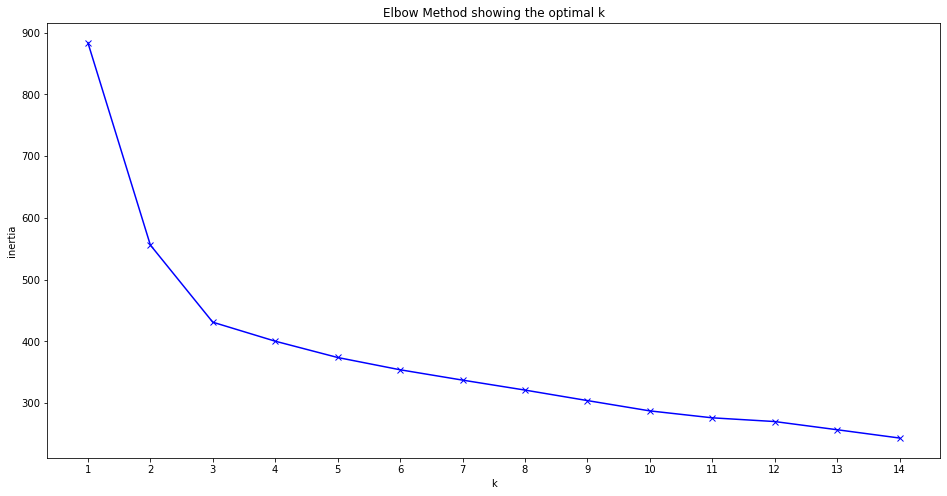

In [130]:
# Elbow method
K = range(1, 15)
print(list(K))
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

print(inertia)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0.30686574426915414, 0.26720047340021413, 0.24459193989835165, 0.23749622806014353, 0.1817058429816769, 0.18777293991480326, 0.14667471739321944, 0.14943902986678076, 0.15379324445029985, 0.1395076885458624, 0.126596219725294, 0.1413432917765, 0.15275021775085498, 0.15827359413005365, 0.1414062951029852, 0.13419912110625265, 0.12145407326250712, 0.11473661755141187]


Text(0.5, 1.0, 'Silhouette Score showing the optimal k')

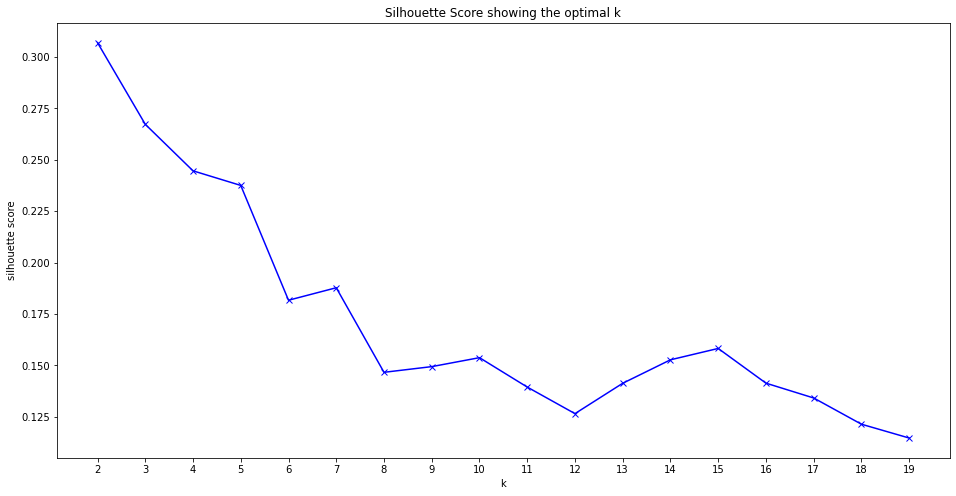

In [132]:
# Silhouette Score
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X)
    silhouette.append(silhouette_score(X, kmeans.predict(X)))

print(list(K))
print(silhouette)

plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Score showing the optimal k')

Looking for upward spike, 7 seems to be the best cluster for this data, even if elbow method seems to predict something different

In [134]:
# PCA for identifying relevant factors for clusters
X_pca = genre_ratings_cleaned
pd.DataFrame(X_pca)

avg_Adventure  avg_Animation  avg_Children  avg_Comedy  avg_Fantasy  \
1             3.69           4.00          3.17        3.27         3.81   
7             3.57           3.50          2.40        3.50         3.21   
22            2.81           3.77          3.10        3.10         3.11   
28            3.44           3.75          3.62        3.43         3.09   
44            3.28           3.42          3.63        3.37         3.58   
..             ...            ...           ...         ...          ...   
628           4.17           4.25          3.94        4.19         4.25   
634           3.12           2.00          3.00        3.35         3.44   
642           3.61           3.67          2.94        2.50         3.37   
659           3.25           2.89          3.30        3.07         3.62   
668           2.79           2.90          2.82        2.63         2.65   

     avg_Romance  avg_Drama  avg_Action  avg_Crime  avg_Thriller  avg_Horror  \
1           3.34       3.84        3.83       4.21          3.87        3.69   
7           3.83       3.44        3.74       3.85          3.72        3.57   
22          3.22       3.45        2.73       3.39          3.23        3.10   
28          3.71       3.55        3.25       3.40          3.32        4.00   
44          3.52       3.20        3.16       3.12          3.20        3.27   
..           ...        ...         ...        ...           ...         ...   
628         4.07       4.26        4.12       4.25          4.16        4.17   
634         3.64       3.80        2.95       3.50          3.46        3.62   
642         3.81       3.68        3.34       3.43          3.84        3.43   
659         3.09       3.29        3.23       3.33          3.28        3.06   
668         2.86       2.91        2.66       2.88          2.67        2.35   

     avg_Mystery  avg_Sci-Fi  avg_IMAX  avg_War  avg_Musical  avg_Documentary  \
1           3.81        3.40      3.88     4.20         4.00             0.50   
7           3.86        3.54      3.17     3.64         5.00             4.00   
22          3.43        2.82      4.50     2.55         2.72             2.50   
28          3.60        3.71      4.00     3.15         3.67             4.00   
44          3.58        3.35      0.50     3.22         3.08             4.50   
..           ...         ...       ...      ...          ...              ...   
628         4.00        4.19      4.33     4.35         4.38             4.60   
634         3.71        3.58      3.50     4.36         2.25             5.00   
642         3.89        3.63      3.19     3.73         1.25             3.42   
659         3.37        2.93      3.41     3.04         3.33             4.20   
668         2.74        2.53      2.78     3.11         2.92             2.96   

     avg_Western  avg_Film-Noir  clusters  
1           3.50           4.00         1  
7           3.00           5.00         1  
22          2.00           3.50         2  
28          3.17           4.00         1  
44          3.20           4.50         1  
..           ...            ...       ...  
628         3.70           4.50         0  
634         4.00           4.50         1  
642         4.62           4.00         1  
659         3.00           3.25         1  
668         3.01           3.28         2  

[119 rows x 20 columns]

In [135]:
pca = PCA()
pca.fit(X_pca)
components = pca.transform(X_pca)
print(pd.DataFrame(components))

           0         1         2         3         4         5         6   \
0   -0.265011  1.834002 -2.759685  0.730777 -0.161311 -0.221373  0.383200   
1   -0.540663 -0.793372 -0.276799  0.118977 -1.343051 -0.386775  1.113313   
2    2.026867  1.362380 -0.369480 -0.660441 -1.055813  0.448462 -0.815387   
3   -0.221427  0.212268  0.446775 -0.159051 -0.613957  0.194915 -0.608667   
4    1.056535 -2.036614  0.578711  1.730697 -0.220217 -0.931994 -0.413979   
..        ...       ...       ...       ...       ...       ...       ...   
114 -3.150566 -0.001050  0.253830  0.100416 -0.599311  0.171970  0.032230   
115  0.079680 -1.802184  0.288879 -0.826998  0.376700  1.168104 -0.035943   
116  0.409321 -0.880699 -0.980442  0.047774  1.319725  1.150641 -1.118431   
117  1.026600  0.011987  0.848637 -0.295355 -0.067298  0.279463  0.038668   
118  3.203879  0.133618 -0.000188 -0.351554  0.240945 -0.450311  0.033813   

           7         8         9         10        11        12        13  

In [136]:
round(pd.DataFrame(pca.explained_variance_ratio_), 5)

0
0   0.58210
1   0.09649
2   0.07831
3   0.05960
4   0.04309
5   0.02938
6   0.01983
7   0.01690
8   0.01358
9   0.01244
10  0.01134
11  0.00900
12  0.00723
13  0.00607
14  0.00495
15  0.00334
16  0.00219
17  0.00172
18  0.00155
19  0.00087

In [ ]:
## Conclusion
* Summarize your data analysis result.
* State your conclusion of your hypothesis testing.
* Interpret your findings in terms of the human-understandable question you try to answer.
* What are the next steps?

In [ ]:
## Data Analysis main project
### Overview
### Data Exploration and Visualization
### Model Training and Evaluation
## Conclusion
* Summarize your data analysis result.
* State your conclusion of your hypothesis testing.
* Interpret your findings in terms of the human-understandable question you try to answer.
* What are the next steps?